In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/gwas/matched"

In [3]:
models = [
    #"CADD.RawScore",
    #"phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    #"InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    #"LongSafari/hyenadna-large-1m-seqlen-hf",
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression",
    "Enformer.LogisticRegression",
    "LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
    "multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression",
]

#embedding_models = [
#    "Enformer",
#    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
#    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
#    "LongSafari/hyenadna-large-1m-seqlen-hf",
#    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
#]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression
0,1,2293397,G,A,0.999863,0.370771,True,-0.537581,-0.631052,-0.371038,-0.945803,-0.452708,-0.391285
1,1,3080038,T,C,0.999997,0.232951,True,-0.793795,-0.715999,-0.589731,-0.493970,-0.787467,-0.854211
2,1,3473193,A,G,1.000000,0.004888,True,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3774964,A,G,0.999972,0.230889,True,-0.656984,-0.839722,-0.812059,-0.681361,-0.735643,-0.707719
4,1,7734229,A,G,0.955835,0.354394,True,-0.450594,-0.664523,-0.357698,-0.486369,-0.455155,-0.392462
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,-0.462438,-0.455294,-0.346404,-0.482622,-0.477057,-0.486329
4594,9,80418212,A,T,0.001858,0.131431,False,-0.233052,-0.117528,-0.317332,-0.302183,-0.198113,-0.202532
4595,9,137457837,C,A,0.002396,0.000404,False,NaN,NaN,NaN,NaN,NaN,NaN
4596,9,4258802,C,G,0.003577,0.165471,False,-0.460323,-0.352212,-0.363074,-0.440885,-0.465014,-0.468976


In [4]:
V["match_group"] = np.concatenate([np.arange(len(V)//2), np.arange(len(V)//2)])
V

,chrom,pos,ref,alt,pip,maf,label,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,match_group
0,1,2293397,G,A,0.999863,0.370771,True,-0.537581,-0.631052,-0.371038,-0.945803,-0.452708,-0.391285,0
1,1,3080038,T,C,0.999997,0.232951,True,-0.793795,-0.715999,-0.589731,-0.493970,-0.787467,-0.854211,1
2,1,3473193,A,G,1.000000,0.004888,True,NaN,NaN,NaN,NaN,NaN,NaN,2
3,1,3774964,A,G,0.999972,0.230889,True,-0.656984,-0.839722,-0.812059,-0.681361,-0.735643,-0.707719,3
4,1,7734229,A,G,0.955835,0.354394,True,-0.450594,-0.664523,-0.357698,-0.486369,-0.455155,-0.392462,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4593,9,131990428,A,T,0.008844,0.319611,False,-0.462438,-0.455294,-0.346404,-0.482622,-0.477057,-0.486329,2294
4594,9,80418212,A,T,0.001858,0.131431,False,-0.233052,-0.117528,-0.317332,-0.302183,-0.198113,-0.202532,2295
4595,9,137457837,C,A,0.002396,0.000404,False,NaN,NaN,NaN,NaN,NaN,NaN,2296
4596,9,4258802,C,G,0.003577,0.165471,False,-0.460323,-0.352212,-0.363074,-0.440885,-0.465014,-0.468976,2297


In [5]:
"""
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()
""";

In [7]:
#V["Enformer_l2"] = -np.linalg.norm(V[features["Enformer"]], axis=1)
#models.append("Enformer_l2")

In [6]:
V.dropna(
    subset=models,# + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,Enformer.LogisticRegression,LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression,multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,match_group
0,1,2293397,G,A,0.999863,0.370771,True,-0.537581,-0.631052,-0.371038,-0.945803,-0.452708,-0.391285,0
1,1,3080038,T,C,0.999997,0.232951,True,-0.793795,-0.715999,-0.589731,-0.493970,-0.787467,-0.854211,1
3,1,3774964,A,G,0.999972,0.230889,True,-0.656984,-0.839722,-0.812059,-0.681361,-0.735643,-0.707719,3
4,1,7734229,A,G,0.955835,0.354394,True,-0.450594,-0.664523,-0.357698,-0.486369,-0.455155,-0.392462,4
5,1,8447713,G,A,0.990299,0.208465,True,-0.393946,-0.353889,-0.425405,-0.429850,-0.307144,-0.366737,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4592,9,123408251,G,C,0.003173,0.141907,False,-0.561643,-0.557764,-0.409886,-0.600042,-0.508395,-0.653888,2293
4593,9,131990428,A,T,0.008844,0.319611,False,-0.462438,-0.455294,-0.346404,-0.482622,-0.477057,-0.486329,2294
4594,9,80418212,A,T,0.001858,0.131431,False,-0.233052,-0.117528,-0.317332,-0.302183,-0.198113,-0.202532,2295
4596,9,4258802,C,G,0.003577,0.165471,False,-0.460323,-0.352212,-0.363074,-0.440885,-0.465014,-0.468976,2297


In [7]:
V = V[V.duplicated("match_group", keep=False)]
n_pos, n_neg = V.label.sum(), (~V.label).sum()
subtitle = f"n={n_pos} vs. {n_neg}"
V.label.value_counts()

label
True     1996
False    1996
Name: count, dtype: int64

In [10]:
"""
for m in embedding_models:
    print(m)
    model_name = f"{m} - full inner product"
    V[model_name] = V[features[m]].sum(axis=1)
    if model_name not in models: models.append(model_name)
""";

Enformer
GPN-MSA
NT
HyenaDNA
GPN-MSA-256


In [8]:
"""
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, roc_auc_score(V_train.label, -V_train[f])]
        for f in tqdm(features)
    ], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', LogisticRegressionCV(
            random_state=42,
            scoring="roc_auc",
            n_jobs=-1,
            max_iter=1000,
            Cs=np.logspace(-5, 0, 10),
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    linear = clf.named_steps["linear"]
    C = linear.C_
    Cs = linear.Cs_
    #if C == Cs[0] or C == Cs[-1]:
    #    raise Exception(f"{C=} {Cs[0]=} {Cs[-1]=}")
    return -clf.predict_proba(V_test[features])[:, 1]

supervised_models = []


for m in embedding_models:
    #supervised_models.append((
    #    f"{m} - best inner product",
    #    lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    #))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))


supervised_models.append((
    f"GPN-MSA + Enformer - LR(inner products+abs(delta features))",
    lambda *args: train_predict_lr(*args, np.concatenate([features["GPN-MSA"], features["Enformer"]])),
))

for split in tqdm(SPLITS):
    mask_train = V.chrom.isin(split)
    mask_test = ~mask_train
    for model_name, model in supervised_models:
        if model_name not in models: models.append(model_name)
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])
""";

In [9]:
# request by yss
-V[V.pos==20381010][models].T

,792
multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,0.801622
InstaDeepAI/nucleotide-transformer-2.5b-multi-species.LogisticRegression,0.312952
Enformer.LogisticRegression,0.862347
LongSafari/hyenadna-large-1m-seqlen-hf.LogisticRegression,0.554510
multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,0.738359
multiz100way/89/512/256/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True.LogisticRegression,0.705946


In [10]:
results = []
for m in models:
    results.append([m, roc_auc_score(V.label, -V[m])])
results = pd.DataFrame(results, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

,Model,AUROC
4,multiz100way/89/256/128/True/defined.phastCons...,0.767293
0,multiz100way/89/128/64/True/defined.phastCons....,0.765438
5,multiz100way/89/512/256/True/defined.phastCons...,0.765127
2,Enformer.LogisticRegression,0.759675
1,InstaDeepAI/nucleotide-transformer-2.5b-multi-...,0.728883
3,LongSafari/hyenadna-large-1m-seqlen-hf.Logisti...,0.615949


In [4]:
#results.to_parquet("results_gwas.parquet", index=False)
#results = pd.read_parquet("results_gwas.parquet")
#results

,Model,AUROC
0,GPN-MSA + Enformer - LR(inner products+abs(del...,0.791782
1,GPN-MSA - LR(inner products),0.764540
2,Enformer - LR(inner products),0.751844
3,GPN-MSA - best inner product,0.745970
4,Enformer_l2,0.728721
5,Enformer - full inner product,0.722889
6,NT - LR(inner products),0.718481
7,Enformer - best inner product,0.680198
8,NT - best inner product,0.666136
9,CADD,0.658744


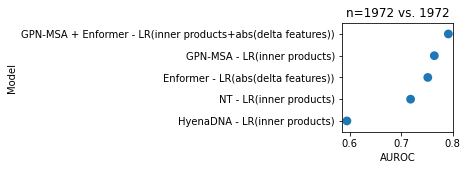

In [31]:
plt.figure(figsize=(2,2))
sns.pointplot(
    data=results[results.Model.str.contains("LR")].replace("Enformer - LR(inner products)", "Enformer - LR(abs(delta features))"),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);
#plt.savefig("plot1.pdf", bbox_inches="tight")

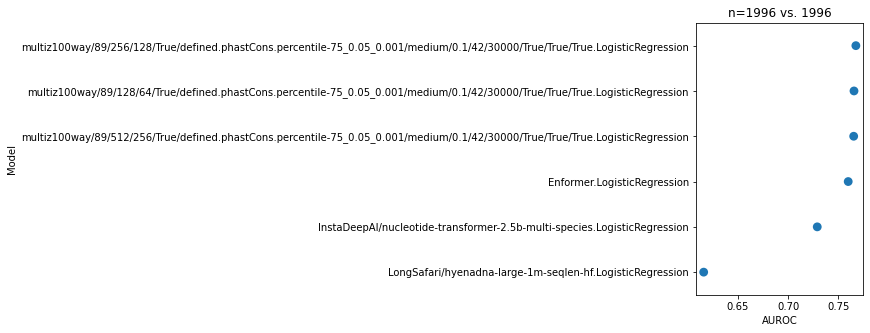

In [11]:
plt.figure(figsize=(3,5))
sns.pointplot(
    data=results,
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);

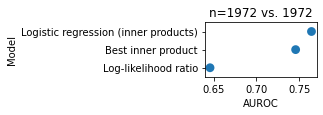

In [29]:
plt.figure(figsize=(2,1))
sns.pointplot(
    data=results[
        results.Model.str.contains("GPN-MSA") & ~results.Model.str.contains("Enformer") & ~results.Model.str.contains("full")
    ].replace({
        "GPN-MSA": "Log-likelihood ratio",
        "GPN-MSA - best inner product": "Best inner product",
        "GPN-MSA - LR(inner products)": "Logistic regression (inner products)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);
#plt.savefig("limitations.pdf", bbox_inches="tight")